Import libraries and useful functions. Code reused from week 4 exercises.

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None, n_classes=10):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        labels=np.arange(n_classes),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

Load the CIFAR-10 dataset and split it into train, calibration and test sets.

In [19]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# Load full training dataset (50,000 samples)
full_train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Split into train (40k) and calibration (10k)
train_size = int(0.8 * len(full_train_set))   # 40,000
calib_size = len(full_train_set) - train_size # 10,000

train_set, calib_set = torch.utils.data.random_split(
    full_train_set, [train_size, calib_size]
)

# Test set remains unchanged
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
calib_loader = DataLoader(calib_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Map from class index to class name.
classes = {index: name for name, index in full_train_set.class_to_idx.items()}

In [25]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.dataset.targets))} (unique labels: {set(train_set.dataset.targets)})")

print("\nCalibration data")
print("Number of points:", len(calib_set))
x, y = next(iter(calib_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(calib_set.dataset.targets))} (unique labels: {set(calib_set.dataset.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 40000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Calibration data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


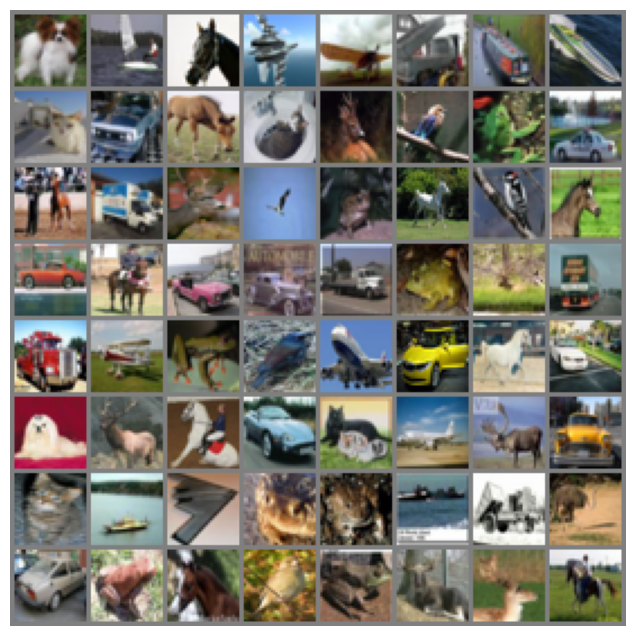

In [26]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

Define model architecture and forward pass.

In [27]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.activation_fn = nn.ReLU

        self.net = nn.Sequential(
            # CNN
            nn.Conv2d(3, 32, 5),
            self.activation_fn(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            self.activation_fn(),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Flatten(),

            # FFNN
            nn.LazyLinear(128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)
    


model = Model(n_classes)
device = torch.device('cpu')  
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


Define loss function and optimizers.

In [28]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-3)  

Train the model.

In [ ]:
num_epochs = 8 ## train model for longer
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.

        # Compute outputs
        output = model(inputs)

        # Compute loss
        loss = loss_fn(output, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # One step of gradient descent
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        # Validate every `validation_every_steps` steps.
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")


print("Finished training.")

Step 500     training accuracy: 0.55359375
Step 1000    training accuracy: 0.6383333333333333
Step 1500    training accuracy: 0.702125
Step 2000    training accuracy: 0.741875
Step 2500    training accuracy: 0.73845
Step 3000    training accuracy: 0.773625
Step 3500    training accuracy: 0.807
Step 4000    training accuracy: 0.841625
Step 4500    training accuracy: 0.87625
Step 5000    training accuracy: 0.858925
Finished training.


In [ ]:
def conformal_prediction(calib_loader, model):
    true_label_prob = []
    alpha = 0.1

    with torch.no_grad():
        for inputs, targets in calib_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)

            # Compute softmax probabilities
            probs = torch.softmax(output, dim=1)

            # Add softmax probabilities for true labels into a list
            for sample in range(len(probs)):
                true_label_prob.append(probs[sample][targets[sample].item()])

        # Compute non-conformity scores
        non_comf_scores = np.zeros(len(true_label_prob))
        for i in range(len(true_label_prob)):
            non_comf_scores[i] = 1 - true_label_prob[i]
        non_comf_scores.sort()
            
        # Compute threshold
        threshold_index = np.ceil((len(non_comf_scores) + 1) * (1 - alpha)) - 1
        threshold = non_comf_scores[int(threshold_index)]
        print(threshold)

    return threshold
    
thresh = conformal_prediction(calib_loader, model)

10000
0.9619689583778381


Evaluate model performance on test set.

In [ ]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)

        probs = torch.softmax(output, dim=1)

        # Prediction set per batch
        pred_set = []

        # Add classes to prediction set
        for i in range(len(probs)):
            for j in range(len(probs[i])):
                if probs[i][j] >= 1 - thresh:
                    pred_set.append(j)

            print("possible classes", pred_set)
            print("true class", targets[i].item())
            pred_set = []

            ## ADD OTHER DIAGNOSTICS FOR PROPER EVALUATION OF THE CONFORMAL PREDICTIONS
        

        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

possible classes [3, 5, 6]
true class 3
possible classes [1, 8]
true class 8
possible classes [0, 8]
true class 8
possible classes [0, 8]
true class 0
possible classes [2, 3, 4, 6]
true class 6
possible classes [6]
true class 6
possible classes [1]
true class 1
possible classes [2, 4, 6]
true class 6
possible classes [3, 4, 5]
true class 3
possible classes [1]
true class 1
possible classes [0]
true class 0
possible classes [9]
true class 9
possible classes [3, 4, 5, 7]
true class 5
possible classes [7]
true class 7
possible classes [9]
true class 9
possible classes [8]
true class 8
possible classes [3, 5]
true class 5
possible classes [2, 3, 5, 7, 9]
true class 7
possible classes [8]
true class 8
possible classes [6]
true class 6
possible classes [3, 4, 5, 7]
true class 7
possible classes [0, 2]
true class 0
possible classes [0, 2]
true class 4
possible classes [9]
true class 9
possible classes [2, 4, 5]
true class 5
possible classes [2, 3, 4]
true class 2
possible classes [4, 7]
true 

Plot confusion matrix for test set.

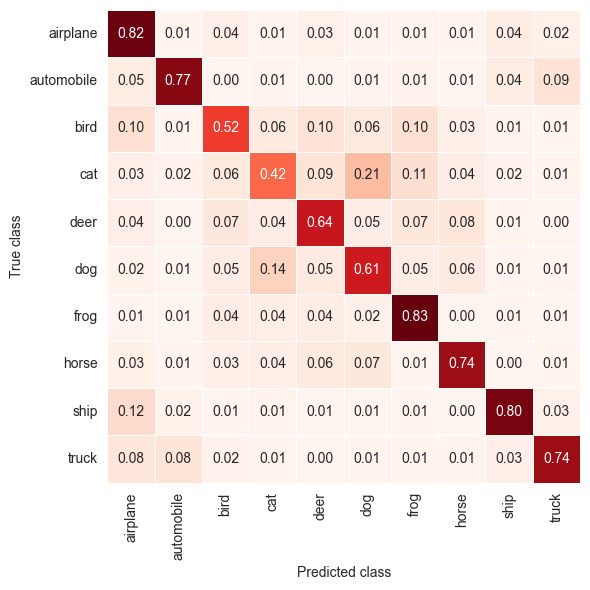

In [73]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Plot per class accuracy of predictions.

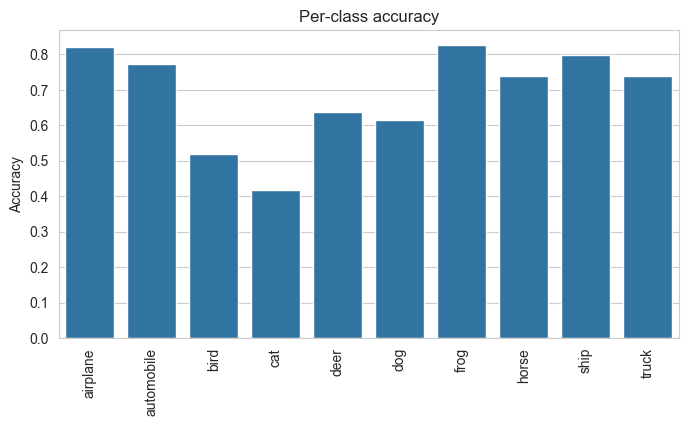

In [74]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()